### Imports

In [1]:
import struct
import os
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import plotly.io as pio # themes
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from IPython.display import HTML
# import matplotlib.colors as mcolors
# import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.stats import binned_statistic

sns.set_style("darkgrid")
sns.set(style='ticks', font_scale=1.3)
sns.set_palette("bright")
plt.rc('font', family='monospace')
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

idx = pd.IndexSlice
bgcolour = "rgb(15, 23, 42)"
plotly_template = pio.templates["plotly_dark"]

# Parameters
G = 2.9599e-4 # gravitational constant [AU^3 / M_solar * days^2]

#### - Data extraction guide

- mass => `mass[i, :]`   - mass of each particle in the snapshot
- pos  => `pos[i, :, :]` - position of each particle in the snapshot
    - x => `pos[i, :, 0]` - x position
    - y => `pos[i, :, 1]` - y position
    - z => `pos[i, :, 2]` - z position
- vel  => `vel[i, :, :]` - velocity of each particle in the snapshot
    - vx => `vel[i, :, 0]` - x velocity
    - vy => `vel[i, :, 1]` - y velocity
    - vz => `vel[i, :, 2]` - z velocity
- acc  => `acc[i, :, :]` - acceleration of each particle in the snapshot
    - ax => `acc[i, :, 0]` - x acceleration
    - ay => `acc[i, :, 1]` - y acceleration
    - az => `acc[i, :, 2]` - z acceleration

... except data manipulation is easier and faster if we pack the data into a dataframe, so we'll do that instead.

```python
mass = df.loc[:,idx[:,'mass']]
x = df.loc[:,idx[:,'x']] # .groupby(level=0, axis=1).sum()
y = df.loc[:,idx[:,'y']]
z = df.loc[:,idx[:,'z']]

fx = df.loc[:,idx[:,'fx']]
fy = df.loc[:,idx[:,'fy']]
fz = df.loc[:,idx[:,'fz']]

vx = df.loc[:,idx[:,'vx']]
vy = df.loc[:,idx[:,'vy']]
vz = df.loc[:,idx[:,'vz']]
```

### Reading & unpacking the binary data file

In [4]:
def process_data(simulation_run_folder):
     
    """
    This code first constructs the path to the out folder for the specific simulation run. It then uses os.listdir to get a list of filenames in the out folder, and filters the list to only include filenames that end with ".bin". The resulting list of snapshot filenames is then sorted, so that the snapshots are processed in order.
    """
     
    snapshot_folder = os.path.join("out", simulation_run_folder)

    snapshot_filenames = []
    for filename in os.listdir(snapshot_folder):
        if filename.endswith(".bin"):
            snapshot_filenames.append(os.path.join(snapshot_folder, filename))

    snapshot_filenames.sort()

    """ 
    This code reads the header data from the binary file - in most cases, we only need to read the first snapshot, since the header data is the same for all snapshots. We will implement a way to read the header data from any snapshot file.
    """

    filename = snapshot_filenames[0]
    with open(filename, 'rb') as f:
        header_dtype = np.dtype([('N', np.int32),
                                ('current_time', np.float32),
                                ('delta_time', np.float32),
                                ('softening_factor', np.float32),
                                ('mass_seed', np.uint32),
                                ('position_seed', np.uint32),
                                ('velocity_seed', np.uint32)])
        
        header = np.frombuffer(f.read(header_dtype.itemsize), header_dtype)

    n_bodies = header['N'][0]
    softening_factor = header['softening_factor'][0]
    mass_seed = header['mass_seed'][0]
    position_seed = header['position_seed'][0]
    velocity_seed = header['velocity_seed'][0]
    total_snapshots = len(snapshot_filenames)

    print("n_bodies: ", n_bodies)
    print("softening_factor: ", softening_factor)
    print("total_snapshots: ", total_snapshots)
    print(f'mass_seed: {mass_seed} | position_seed: {position_seed} | velocity_seed: {velocity_seed}')
    
    """
    This code reads each binary snapshot file in turn using `np.frombuffer`, and returns the data as a numpy array. The data is then reshaped to the correct dimensions, and the mass, position, velocity, and force data is extracted. 
    """

    mass = np.zeros((total_snapshots, n_bodies), dtype=np.float32)
    pos = np.zeros((total_snapshots, n_bodies, 3), dtype=np.float32)
    vel = np.zeros((total_snapshots, n_bodies, 3), dtype=np.float32)
    acc = np.zeros((total_snapshots, n_bodies, 3), dtype=np.float32)
    current_time = np.zeros((total_snapshots,), dtype=np.float32)
    delta_time = np.zeros((total_snapshots,), dtype=np.float32)

    for index, snapshot_filename in enumerate(snapshot_filenames):
        with open(snapshot_filename, "rb") as f:
            header = np.frombuffer(f.read(header_dtype.itemsize), header_dtype)
            current_time[index] = header['current_time'][0]
            delta_time[index] = header['delta_time'][0]

            snapshot = np.frombuffer(f.read(), dtype=np.float32)
            snapshot = snapshot.reshape((n_bodies, 10))

            mass[index, :] = snapshot[:, 0]
            pos[index, :, :] = snapshot[:, 1:4]
            vel[index, :, :] = snapshot[:, 4:7]
            acc[index, :, :] = snapshot[:, 7:10]

    total_time = current_time[-1]
    print(f'total_time: {total_time:.2f} days | {total_time/365.25:.4f} yrs')

    """ 
    This code extracts the mass, position, velocity, and force data from the numpy arrays, and stores it in a pandas DataFrame. The DataFrame is then returned, along with the header data.
    """

    df_list = []
    for i in range(n_bodies):
        data = {
            "mass": mass[:, i],
            "x": pos[:, i, 0],
            "y": pos[:, i, 1],
            "z": pos[:, i, 2],
            "vx": vel[:, i, 0],
            "vy": vel[:, i, 1],
            "vz": vel[:, i, 2],
            "fx": acc[:, i, 0],
            "fy": acc[:, i, 1],
            "fz": acc[:, i, 2],
            "current_time": current_time,
            "delta_time": delta_time
        }
        df_list.append(pd.DataFrame(data))

    df = pd.concat(df_list, axis=1, keys=["{}".format(i) for i in range(n_bodies)])

    """
    This code creates a numpy array that contains the snapshot index and the current time for each snapshot. This array is returned along with the DataFrame, header data, and other useful information.
    """

    snapshot_indices = np.arange(total_snapshots)
    current_time_array = df[("0", "current_time")].values

    time_arr = np.column_stack((snapshot_indices, current_time_array))

    delta_time_arr = df[("0", "delta_time")].values

    return df, time_arr, current_time_array, delta_time_arr, n_bodies, softening_factor, total_snapshots, total_time


### Energy calculation
Here we calculate the total gravitational potential energy and kinetic energy of the system as a whole throughout the simulation.

In [5]:
def systemEnergy(data):
    # Gravitational Potential Energy
    fx, fy, fz = data.loc[:,idx[:,'fx']], data.loc[:,idx[:,'fy']], data.loc[:,idx[:,'fz']]
    fx_sum, fy_sum, fz_sum = fx.cumsum(axis=1), fy.cumsum(axis=1), fz.cumsum(axis=1)
    f_sum = np.sqrt(fx_sum.iloc[:,-1]**2 + fy_sum.iloc[:,-1]**2 + fz_sum.iloc[:,-1]**2)
    gravPotEnergy = 0.5 * (f_sum)

    # Kinetic Energy
    mass = (data.loc[:,idx[:,'mass']]).groupby(level=0, axis=1).sum()
    vx, vy, vz = data.loc[:,idx[:,'vx']], data.loc[:,idx[:,'vy']], data.loc[:,idx[:,'vz']]
    vxSq, vySq, vzSq = vx**2, vy**2, vz**2
    vxSq, vySq = vxSq.align(vySq, fill_value=0)
    vxSq, vzSq = vxSq.align(vzSq, fill_value=0)
    vxSq, vySq = vxSq.align(vySq, fill_value=0)
    vMag = (vxSq + vySq + vzSq).groupby(level=0, axis=1).sum()
    kineticEnergy = (0.5 * mass * vMag**2).cumsum(axis=1).iloc[:,-1]

    print("Gravitational Potential Energy: ", gravPotEnergy.iloc[-1])
    print("Kinetic Energy: ", kineticEnergy.iloc[-1])
    print("Total Energy: ", gravPotEnergy.iloc[-1] + kineticEnergy.iloc[-1])

    return gravPotEnergy, kineticEnergy, gravPotEnergy + kineticEnergy

### Binary Finder

To determine if two stars are gravitationally bound in a binary system, we need to compare the gravitational force between them and compare it to the kinetic energy between them. If the kinetic energy is greater than the gravitational force, then the two stars are gravitationally bound.

In [6]:
def find_bound_pairs(data, total_snapshots, n_bodies):
    
    x  = data.loc[:,idx[:,'x']].groupby(level=0, axis=1).sum()
    y  = data.loc[:,idx[:,'y']].groupby(level=0, axis=1).sum()
    z  = data.loc[:,idx[:,'z']].groupby(level=0, axis=1).sum()
    vx = data.loc[:,idx[:,'vx']].groupby(level=0, axis=1).sum()
    vy = data.loc[:,idx[:,'vy']].groupby(level=0, axis=1).sum()
    vz = data.loc[:,idx[:,'vz']].groupby(level=0, axis=1).sum()
    m  = data.loc[:,idx[:,'mass']].groupby(level=0, axis=1).sum()

    is_bound = np.zeros((total_snapshots, n_bodies), dtype=bool)  # Initialize boolean array
    bound_to = [[[] for l in range(n_bodies)] for m in range (total_snapshots)]  # Initialize empty array for 
    pairs = [[]for b in range(total_snapshots)]  # Initialize empty array for pairs
    print(pairs[0])

    for i in range(0, n_bodies - 1):
        for j in range(i + 1, n_bodies):
            r1 = np.sqrt(x.iloc[:,i]**2 + y.iloc[:,i]**2 + z.iloc[:,i]**2)
            r2 = np.sqrt(x.iloc[:,j]**2 + y.iloc[:,j]**2 + z.iloc[:,j]**2)

            v1 = np.sqrt(vx.iloc[:,i]**2 + vy.iloc[:,i]**2 + vz.iloc[:,i]**2)
            v2 = np.sqrt(vx.iloc[:,j]**2 + vy.iloc[:,j]**2 + vz.iloc[:,j]**2)
            
            m1, m2 = m.iloc[:,i], m.iloc[:,j]

            # Calculate centre of mass position & velocity
            r_com = (m1 * r1 + m2 * r2) / (m1 + m2)
            v_com = (m1 * v1 + m2 * v2) / (m1 + m2)

            # Apply centre of mass correction to relative position & velocity
            r1 -= r_com; r2 -= r_com
            v1 -= v_com; v2 -= v_com

            KE = 0.5 * m1 * v1**2 + 0.5 * m2 * v2**2
            GPE = -G * m1 * m2 / (r1 - r2)**2

            for k in range(0, total_snapshots):
                
                # Check if sum of kinetic and potential energy is negative (bound)
                if KE.iloc[k] + GPE.iloc[k] < 0:
                    pairs[k].append((i, j))
    
    # Add is_bound and bound_to columns to dataframe
    # for i in range(0, n_bodies):
    #     data[f'{i}', 'bound'] = is_bound[:,i]
    data['pairs'] = pairs

    return data 

In [21]:
# def calculate_bound_pairs(simulation_run_folder):
#     df, time_arr, current_time_array, delta_time_arr, n_bodies, softening_factor, total_snapshots, total_time = process_data(simulation_run_folder)

#      # Calculate bound pairs
#     bound_data = find_bound_pairs(df, total_snapshots, n_bodies)
#     bound_pairs = bound_data['pairs']
#     masses = df.loc[:, (slice(None), 'mass')].to_numpy().flatten()

#     return bound_pairs, masses, current_time_array

# simulation_run_folders = ["n-10-cluster-06", "n-10-cluster-07", "n-10-cluster-08", "n-10-cluster-09", "n-10-cluster-10",
#                           "n-10-cluster-11", "n-10-cluster-12", "n-10-cluster-13", "n-10-cluster-14", "n-10-cluster-15",
#                           "n-10-cluster-16", "n-10-cluster-17", "n-10-cluster-18", "n-10-cluster-19", "n-10-cluster-20"]  # Add more simulation run folder names as needed
# all_binary_counts = []
# all_current_time_arrays = []

# for simulation_run_folder in simulation_run_folders:
#     bound_pairs, masses, current_time_array = calculate_bound_pairs(simulation_run_folder)
#     binary_counts = [len(pairs) for pairs in bound_pairs]
#     all_binary_counts.append(binary_counts)
#     all_current_time_arrays.append(current_time_array)

# # Ensure all current_time_arrays are the same
# assert all(np.array_equal(all_current_time_arrays[0], x) for x in all_current_time_arrays)

# Calculate the average binary counts for all simulations
avg_binary_counts = np.mean(all_binary_counts, axis=0)


/usr/lib/python3/dist-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


In [186]:
print(combined_bound_pairs)
print(combined_masses)

[list([(0, 2), (0, 5), (0, 8), (1, 3), (2, 5), (4, 6), (4, 8), (5, 8), (7, 9)])
 list([(0, 2), (0, 5), (0, 8), (1, 3), (2, 5), (4, 6), (4, 8), (5, 8), (7, 9)])
 list([(0, 2), (0, 5), (0, 8), (1, 3), (2, 5), (4, 6), (4, 8), (5, 8), (7, 9)])
 ... list([]) list([]) list([])]
[2.907822   0.97001326 0.36154005 ... 1.3915504  1.3074511  0.950383  ]


In [187]:
# Initialize an empty list to store the binary counts and mass bin labels
binary_counts_data = []

# Define the minimum and maximum mass values
min_mass = 0.01
max_mass = combined_masses.max()

# Define the number of logarithmic mass bins
num_bins = 8

# Create an array of logarithmically spaced mass bins
mass_bins = np.logspace(np.log10(min_mass), np.log10(max_mass), num_bins + 1)

for simulation_run, pairs in enumerate(combined_bound_pairs):
    for i in range(num_bins):
        mass_bin = (mass_bins[i], mass_bins[i + 1])
        label = f'{mass_bin[0]:.2f}-{mass_bin[1]:.2f}'
        mass_bin_pairs = [pair for pair in pairs if mass_bin[0] <= combined_masses[pair[0]] < mass_bin[1]]
        binary_counts_data.append({'Simulation Run': simulation_run, 'Mass Bin': label, 'Binary Count': len(mass_bin_pairs)})

# Create a DataFrame containing the binary counts per mass bin
binary_counts_df = pd.DataFrame(binary_counts_data)

# Create a Seaborn grouped boxplot to visualize the binary counts per mass bin
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=binary_counts_df, x="Mass Bin", y="Binary Count", hue="Simulation Run", palette="viridis")
ax.set_title('Binary Counts per Mass Bin')
ax.set_xlabel('Mass Bin (M$_\odot$)')
ax.set_ylabel('Binary Count')
plt.show()


/usr/lib/python3/dist-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step


KeyboardInterrupt: 

/usr/lib/python3/dist-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step


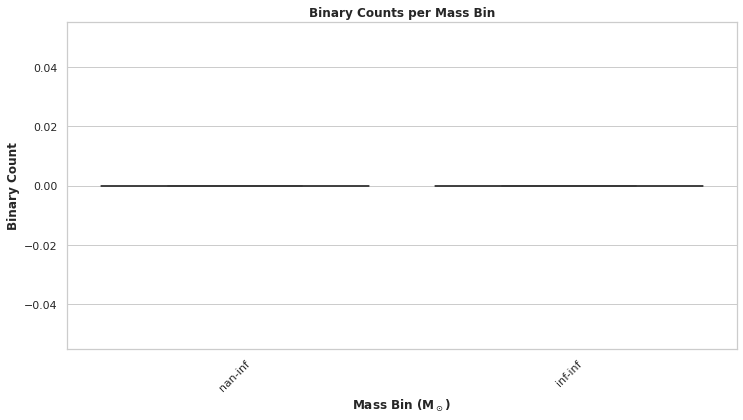

In [182]:
# Define the minimum and maximum mass values
min_mass = 0.01
max_mass = combined_masses.max() + 1

# Define the number of logarithmic mass bins
num_bins = 8

# Create an array of logarithmically spaced mass bins
mass_bins = np.logspace(np.log10(min_mass), np.log10(max_mass), num_bins+1)

# Initialize an empty list to store the binary counts and mass bin labels
binary_counts_data = []

for i in range(num_bins):
    mass_bin = (mass_bins[i], mass_bins[i+1])
    label = f'{mass_bin[0]:.2f}-{mass_bin[1]:.2f}'
    for pairs in combined_bound_pairs:  # 'combined_bound_pairs' should be a list containing the 'pairs' arrays of all simulations
        mass_bin_pairs = [pair for pair in pairs if mass_bin[0] <= combined_masses[pair[0]] < mass_bin[1]]
        binary_counts_data.append({'Mass Bin': label, 'Binary Count': len(mass_bin_pairs)})

# Create a DataFrame containing the binary counts per mass bin
binary_counts_df = pd.DataFrame(binary_counts_data)

# Create a Seaborn grouped boxplot to visualize the binary counts per mass bin
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=binary_counts_df, x="Mass Bin", y="Binary Count", palette="viridis")
ax.set_title('Binary Counts per Mass Bin')
ax.set_xlabel('Mass Bin (M$_\odot$)')
ax.set_ylabel('Binary Count')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()

### Ejection timescales

In [8]:
# Define the threshold distance for ejection
ejection_distance_threshold = 5000  # Adjust this value as needed

def calculate_distance(x1, y1, z1, x2, y2, z2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)

def calculate_escape_velocity(mass, distance):
    G = 2.9599e-4  # Gravitational constant in AU^3 / M_solar * days^2
    return np.sqrt(2 * G * mass / distance)

def find_ejection_timescale(df, n_bodies, total_snapshots):
    ejection_timescales = np.zeros(n_bodies)
    ejected_star_masses = np.zeros(n_bodies)

    for i in range(n_bodies):
        # Get position and velocity data for the current protostar
        x = df[f"{i}"]["x"].values
        y = df[f"{i}"]["y"].values
        z = df[f"{i}"]["z"].values
        vx = df[f"{i}"]["vx"].values
        vy = df[f"{i}"]["vy"].values
        vz = df[f"{i}"]["vz"].values

        # Calculate the distance from the protostar to the cluster center (0, 0, 0)
        distances = calculate_distance(x, y, z, 0, 0, 0)

        # Calculate the escape velocity for each time step
        escape_velocities = calculate_escape_velocity(df[f"{i}"]["mass"].values[0], distances)

        # Determine the time step when the protostar is considered ejected
        ejection_time_step = np.argmax((distances > ejection_distance_threshold) & (np.sqrt(vx**2 + vy**2 + vz**2) > escape_velocities))

        # Calculate the ejection timescale for the current protostar
        if ejection_time_step > 0:
            ejection_timescales[i] = df[f"{i}"]["current_time"].values[ejection_time_step]
            ejected_star_masses[i] = df[f"{i}"]["mass"].values[0]
        else:
            ejection_timescales[i] = -1  # No ejection found
            ejected_star_masses[i] = -1  # No ejection found


    print("Ejection timescales:", ejection_timescales)
    return ejection_timescales, ejected_star_masses

In [9]:
def calculate_ejection_timescales(simulation_run_folder):
    df, time_arr, current_time_array, delta_time_arr, n_bodies, softening_factor, total_snapshots, total_time = process_data(simulation_run_folder)
    
    # Calculate the ejection timescales
    ejection_timescales, ejected_star_masses = find_ejection_timescale(df, n_bodies, softening_factor)

    return ejection_timescales, ejected_star_masses

SIMULATION_BASE = "n-10-cl-parallel"

# Set the directory where the folders are located
directory = "out"
# Get the list of all folders in the directory
all_folders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
# Filter the folders based on the SIMULATION_BASE name
simulation_run_folders = [folder for folder in all_folders if folder.startswith(SIMULATION_BASE)]
print(simulation_run_folders)

all_ejection_timescales = []
all_ejected_star_masses = []

for simulation_run_folder in simulation_run_folders:
    ejection_timescales, ejected_star_masses = calculate_ejection_timescales(simulation_run_folder)
    all_ejection_timescales.append(ejection_timescales)
    all_ejected_star_masses.append(ejected_star_masses)

# Combine ejection timescales and ejected star masses from all simulation runs
combined_ejection_timescales = np.concatenate(all_ejection_timescales)
combined_ejected_star_masses = np.concatenate(all_ejected_star_masses)
print("Combined ejection timescales:", combined_ejection_timescales)
print("Combined ejected star masses:", combined_ejected_star_masses)

['n-10-cl-parallel-053', 'n-10-cl-parallel-063', 'n-10-cl-parallel-091', 'n-10-cl-parallel-109', 'n-10-cl-parallel-108', 'n-10-cl-parallel-080', 'n-10-cl-parallel-039', 'n-10-cl-parallel-025', 'n-10-cl-parallel-107', 'n-10-cl-parallel-112', 'n-10-cl-parallel-1', 'n-10-cl-parallel-5', 'n-10-cl-parallel-078', 'n-10-cl-parallel-065', 'n-10-cl-parallel-104', 'n-10-cl-parallel-029', 'n-10-cl-parallel-026', 'n-10-cl-parallel-119', 'n-10-cl-parallel-15', 'n-10-cl-parallel-3', 'n-10-cl-parallel-049', 'n-10-cl-parallel-072', 'n-10-cl-parallel-13', 'n-10-cl-parallel-034', 'n-10-cl-parallel-052', 'n-10-cl-parallel-100', 'n-10-cl-parallel-086', 'n-10-cl-parallel-083', 'n-10-cl-parallel-057', 'n-10-cl-parallel-10', 'n-10-cl-parallel-058', 'n-10-cl-parallel-055', 'n-10-cl-parallel-061', 'n-10-cl-parallel-101', 'n-10-cl-parallel-6', 'n-10-cl-parallel-075', 'n-10-cl-parallel-069', 'n-10-cl-parallel-030', 'n-10-cl-parallel-045', 'n-10-cl-parallel-11', 'n-10-cl-parallel-021', 'n-10-cl-parallel-093', 'n-

#### - Data retrieval 

In [36]:
df, time_arr, current_time_arr, delta_time_arr, n_bodies, softening_factor, total_snapshots, total_time = process_data("n-50-cluster-04")
GPE, KE, totalE = systemEnergy(df)
df = find_bound_pairs(df, total_snapshots, n_bodies)
binary_counts = df['pairs'].apply(lambda row: sum(1 for _ in row))
# ejection_timescales = find_ejection_timescale(df, n_bodies, total_snapshots)

n_bodies:  50
softening_factor:  0.000125
total_snapshots:  35745
mass_seed: 33 | position_seed: 22 | velocity_seed: 21
total_time: 36524028.00 days | 99997.3388 yrs
Gravitational Potential Energy:  1.8724652e-06
Kinetic Energy:  1.9427805795957208e-07
Total Energy:  2.066743248859247e-06
[]


### Plotting the data

##### - Plotting ejection timescales

Maximum timescale: 9917.66803559206
Location of maximum timescale: 27


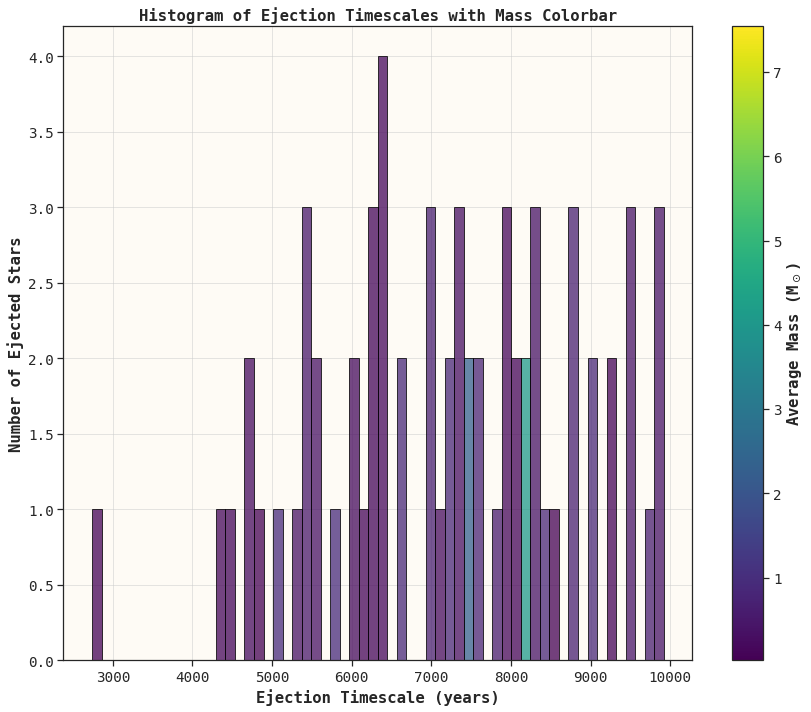

In [10]:
# Filter out the non-ejected stars (-1 in ejection timescales)
# delete index 33 from ejected_timescales and ejected_masses 
# combined_ejection_timescales[33] = -1
# combined_ejected_star_masses[33] = -1

ejected_indices = combined_ejection_timescales != -1

ejected_timescales = combined_ejection_timescales[ejected_indices]/365.25
ejected_masses = combined_ejected_star_masses[ejected_indices]
# TEMPORARY
# delete index 33 from ejected_timescales and ejected_masses 
# ejected_timescales = np.delete(ejected_timescales, 33)
# ejected_masses = np.delete(ejected_masses, 33)
# ejected_timescales = np.delete(ejected_timescales, 96)
# ejected_masses = np.delete(ejected_masses, 96)



# print maximum timescale
print("Maximum timescale:", np.max(ejected_timescales))
# print location of maximum timescale
print("Location of maximum timescale:", np.argmax(ejected_timescales))

# Create the histogram plot with colorbar for mass
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
ax.grid(axis='both', alpha=0.5)
ax.set_facecolor((254/255, 251/255, 245/255, 1))
n, bins, patches = ax.hist(ejected_timescales, bins=60, alpha=0.75, edgecolor='black')

# Color each bin by the average mass of the ejected stars in that bin
norm = Normalize(ejected_masses.min(), ejected_masses.max())
cmap = plt.cm.viridis

for i in range(len(bins) - 1):
    bin_indices = (ejected_timescales >= bins[i]) & (ejected_timescales < bins[i+1])
    if np.sum(bin_indices) > 0:
        average_mass = np.mean(ejected_masses[bin_indices])
        color = cmap(norm(average_mass))
        patches[i].set_fc(color)

# Add colorbar for mass
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='Average Mass (M$_\odot$)')

ax.set_xlabel('Ejection Timescale (years)')
ax.set_ylabel('Number of Ejected Stars')
ax.set_title('Histogram of Ejection Timescales with Mass Colorbar')
plt.tight_layout()
plt.show()

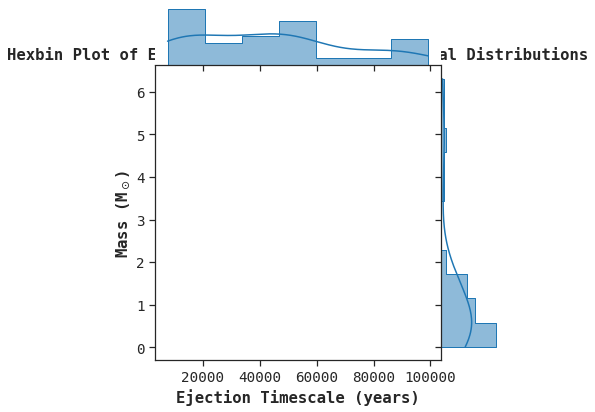

In [133]:
# Create a DataFrame containing ejected timescales and their corresponding masses
hexbin_data = {
    "Ejected Timescale": ejected_timescales,
    "Mass": ejected_masses
}

hexbin_df = pd.DataFrame(hexbin_data)

# Create a hexbin plot with marginal distributions using Seaborn
g = sns.JointGrid(data=hexbin_df, x="Ejected Timescale", y="Mass", space=0)
g.plot_joint(plt.hexbin, cmap="viridis", gridsize=50, mincnt=1, C=np.ones_like(ejected_timescales), reduce_C_function=np.sum)
g.plot_marginals(sns.histplot, element="step", color="#1f77b4", kde=True)

# cbar_ax = g.fig.add_axes([1.05, 0.1, 0.02, 0.7])  # Add a new axes for the colorbar
# g.fig.colorbar(g.ax_joint.collections[0], cax=cbar_ax, label='Number of Stars')

g.ax_joint.set_xlabel('Ejection Timescale (years)')
g.ax_joint.set_ylabel('Mass (M$_\odot$)')
g.ax_joint.set_title('Hexbin Plot of Ejection Timescales with Marginal Distributions')

# plt.tight_layout()
plt.show()

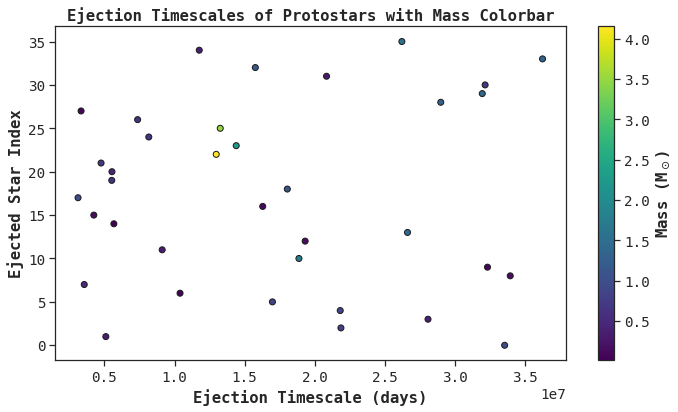

In [89]:

# Filter out the non-ejected stars (-1 in ejection timescales)
ejected_indices = combined_ejection_timescales != -1
ejected_timescales = combined_ejection_timescales[ejected_indices]
ejected_masses = combined_ejected_star_masses[ejected_indices]

# Create the histogram plot with colorbar for mass
plt.figure(figsize=(10, 6))
sc = plt.scatter(ejected_timescales, np.arange(len(ejected_timescales)), c=ejected_masses, cmap='viridis', marker='o', edgecolors='k')
plt.colorbar(sc, label='Mass (M$_\odot$)')
plt.xlabel('Ejection Timescale (days)')
plt.ylabel('Ejected Star Index')
plt.title('Ejection Timescales of Protostars with Mass Colorbar')
plt.tight_layout()
plt.show()

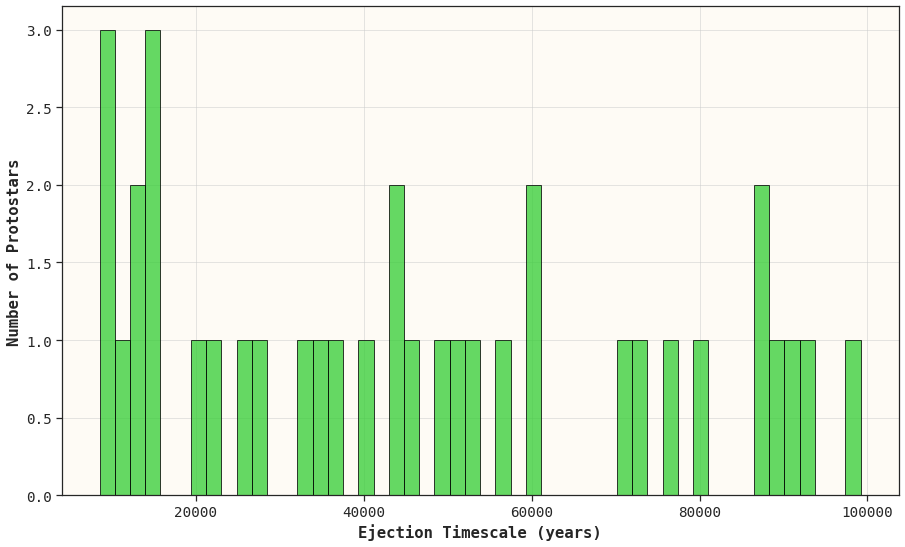

In [81]:
# Remove protostars that were not ejected (ejection timescale == -1)
ejected_timescales = ejection_timescales[ejection_timescales != -1]
combined_ejection_timescales = combined_ejection_timescales[combined_ejection_timescales != -1]

# Create the histogram
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
ax.grid(axis='both', alpha=0.5)
ax.set_facecolor((254/255, 251/255, 245/255, 1))
# plt.hist(ejected_timescales, bins=50, alpha=0.75)
plt.hist(combined_ejection_timescales/365.25, bins=50, alpha=0.75, color='limegreen', edgecolor='black')
plt.xlabel("Ejection Timescale (years)")
plt.ylabel("Number of Protostars")
# plt.title(f'Ejection Timescales of Protostars [N = {n_bodies}]')
# plt.grid(True)
plt.show()

##### - Plotting mean ejection timescales for each mass

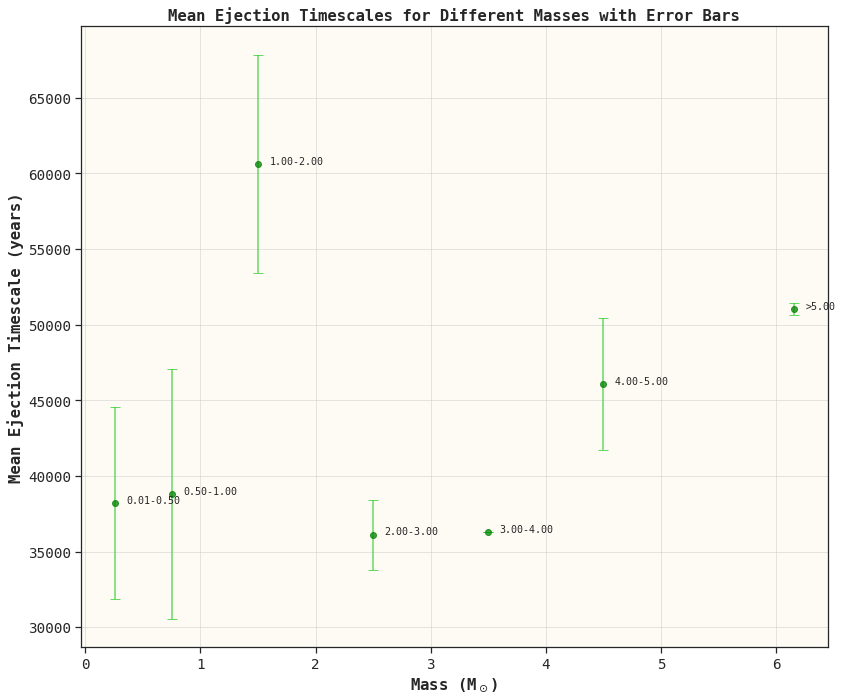

In [118]:
import numpy as np

# Define custom mass bins
mass_bins = np.array([0.01, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, ejected_masses.max() + 1])

# Calculate the mean ejection timescale and its standard error for each mass bin
mean_timescales = np.zeros(len(mass_bins) - 1)
standard_errors = np.zeros(len(mass_bins) - 1)

for i in range(len(mass_bins) - 1):
    bin_indices = (ejected_masses >= mass_bins[i]) & (ejected_masses < mass_bins[i+1])
    bin_timescales = ejected_timescales[bin_indices]
    
    if bin_timescales.size > 0:
        mean_timescales[i] = np.mean(bin_timescales)
        standard_errors[i] = np.std(bin_timescales) / np.sqrt(bin_timescales.size)
    else:
        mean_timescales[i] = np.nan
        standard_errors[i] = np.nan

# Create a plot with error bars
fig, ax = plt.subplots(figsize=(12, 10))
ax.errorbar((mass_bins[:-1] + mass_bins[1:]) / 2, mean_timescales, yerr=standard_errors, fmt='o',
            capsize=5, color='green', alpha=0.75, ecolor='limegreen')

# Add annotations for mass bin ranges
x_offset = 0.1
y_offset = 0.0

for i in range(len(mass_bins) - 1):
    if i == len(mass_bins) - 2:
        mass_range_str = f">{mass_bins[i]:.2f}"
    else:
        mass_range_str = f"{mass_bins[i]:.2f}-{mass_bins[i+1]:.2f}"
    x_pos = (mass_bins[i] + mass_bins[i+1]) / 2 + x_offset
    y_pos = mean_timescales[i] + y_offset
    ax.annotate(mass_range_str, (x_pos, y_pos), fontsize=10)

ax.set_xlabel('Mass (M$_\odot$)')
ax.set_ylabel('Mean Ejection Timescale (years)')
ax.set_title('Mean Ejection Timescales for Different Masses with Error Bars')
ax.grid(axis='both', alpha=0.5)
ax.set_facecolor((254/255, 251/255, 245/255, 1))

plt.tight_layout()
plt.show()


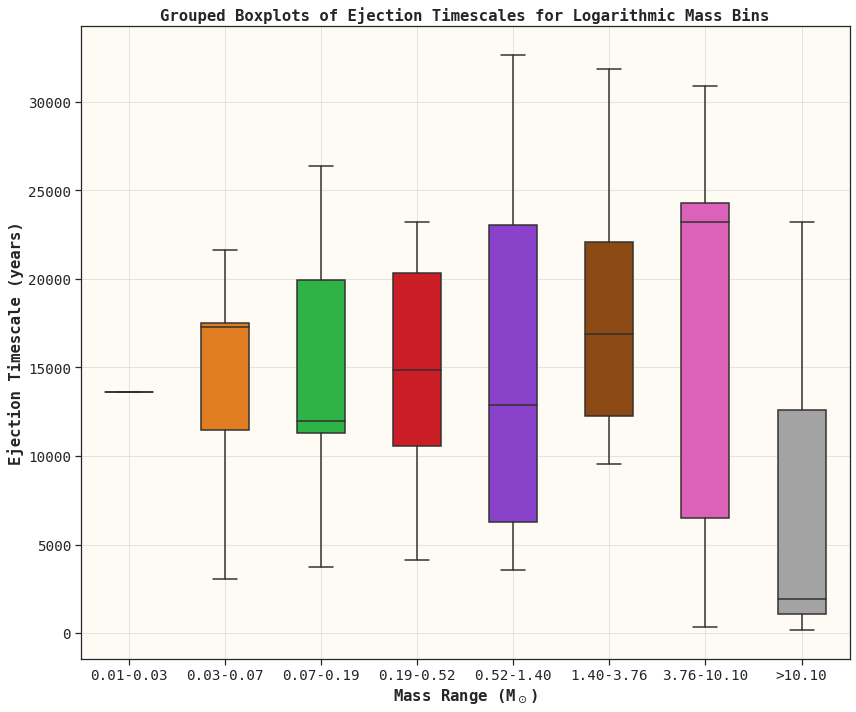

In [18]:
# Define the minimum and maximum mass values
min_mass = 0.01
max_mass = ejected_masses.max() + 1

# Define the number of logarithmic mass bins
num_bins = 8

# Create an array of logarithmically spaced mass bins
mass_bins = np.logspace(np.log10(min_mass), np.log10(max_mass), num_bins+1)

# Define custom mass bins
# mass_bins = np.array([0.01, 0.2, 0.5, 1.0, 2.0, 4.0, 8.0, ejected_masses.max() + 1])

# Calculate the mean ejection timescale and its standard error for each mass bin
mean_timescales = np.zeros(len(mass_bins) - 1)
standard_errors = np.zeros(len(mass_bins) - 1)

# Create a DataFrame containing ejected timescales and their corresponding mass bins
ejected_data = {
    "Ejected Timescale": [],
    "Mass Bin": []
}

for i in range(len(mass_bins) - 1):
    bin_indices = (ejected_masses >= mass_bins[i]) & (ejected_masses < mass_bins[i+1])
    bin_timescales = ejected_timescales[bin_indices]

    if bin_timescales.size > 0:
        ejected_data["Ejected Timescale"].extend(bin_timescales)

        if i == len(mass_bins) - 2:
            mass_range_str = f">{mass_bins[i]:.2f}"
        else:
            mass_range_str = f"{mass_bins[i]:.2f}-{mass_bins[i+1]:.2f}"
        
        ejected_data["Mass Bin"].extend([mass_range_str] * len(bin_timescales))

ejected_df = pd.DataFrame(ejected_data)

# Create a grouped boxplot using Seaborn
fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(x="Mass Bin", y="Ejected Timescale", data=ejected_df, ax=ax, width=0.5)

# ax.set_xlabel('$\mathbf{\log_{10} Mass}$ (M$_\odot$)')
ax.set_xlabel('Mass Range (M$_\odot$)')
ax.set_ylabel('Ejection Timescale (years)')
ax.set_title('Grouped Boxplots of Ejection Timescales for Logarithmic Mass Bins')
ax.grid(axis='both', alpha=0.5)
ax.set_facecolor((254/255, 251/255, 245/255, 1))
#set log scale for x axis
plt.tight_layout()
plt.show()

##### - Plotting the binary stars

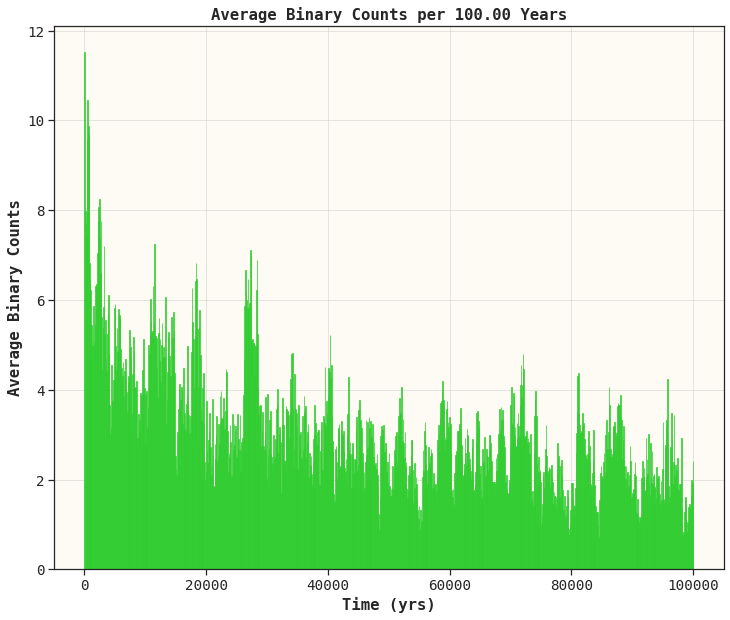

In [37]:
# binary_counts = df['pairs'].apply(lambda row: sum(1 for _ in row))

# Set data
step_time = 100.0 # in years
x_data = current_time_arr / 365.25
y_data = binary_counts

# Calculate the number of bins
total_time = x_data[-1] - x_data[0]
num_bins = int(np.ceil(total_time / step_time))

# Calculate the bin edges
bin_edges = np.linspace(x_data[0], x_data[-1], num_bins + 1)

# Calculate the bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the bin values
bin_values, _ = np.histogram(x_data, bins=bin_edges, weights=binary_counts)

# Divide by the actual bin width to get the average
bin_widths = np.diff(bin_edges)
bin_values = np.array(bin_values, dtype=float)
bin_values /= bin_widths

# Create bar plot using matplotlib
# plt.style.use('bmh')
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
ax.bar(bin_centers, bin_values, width=step_time,color='limegreen', edgecolor='limegreen', alpha=0.75)
ax.grid(axis='both', alpha=0.5)
ax.set_facecolor((254/255, 251/255, 245/255, 1))

# Set labels and title
ax.set_xlabel('Time (yrs)')
ax.set_ylabel('Average Binary Counts')
ax.set_title(f'Average Binary Counts per {step_time:.2f} Years')

# Show the plot
plt.show()

In [13]:
# bound = (df.loc[:,idx[:,'bound']] == True).groupby(level=0, axis=1).sum()
# bound_pairs = (df.loc[:,idx[:,'bound_to']])
# bound_pairs = df[df.loc[:,idx[:,'bound']].any(axis=1)]  # filter to only include rows where any body is bound
# bound_pairs.loc[:,idx[:, ['x']]].plot()
##### **Energy of System**

In [14]:
print(delta_time_arr.shape)
print(current_time_arr.shape)

(35790,)
(35790,)


4.378430541446143e-07


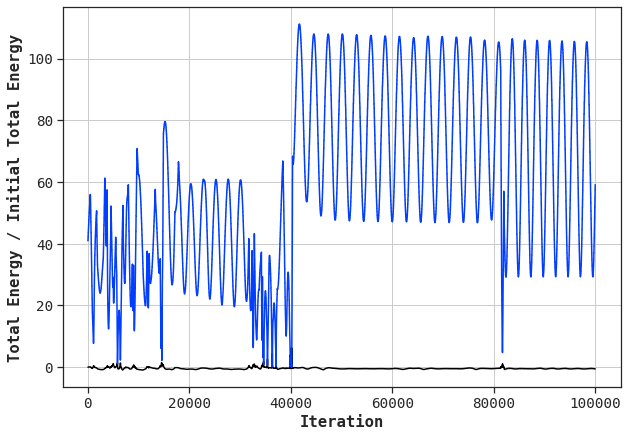

In [31]:
# Create plot environment
# plt.style.use('bmh')
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax.grid(True)

# Variable setting
# x_data = np.arange(0, total_);
x_data = current_time_arr / 365.25
y_data = ((totalE - totalE[0]) / totalE[0]) 

# Plot graph
plt.plot(x_data, y_data, color="black", label="$\mathrm{E}_{\mathrm{total}}$ change");
plt.plot(x_data,delta_time_arr)
# plt.title("Total Energy Change")
plt.xlabel("Iteration");
plt.ylabel("Total Energy / Initial Total Energy")
print(totalE[0])

**Energy Conservation**

In [33]:
# plt.plot(current_time_arr)
# print(time_arr.shape)

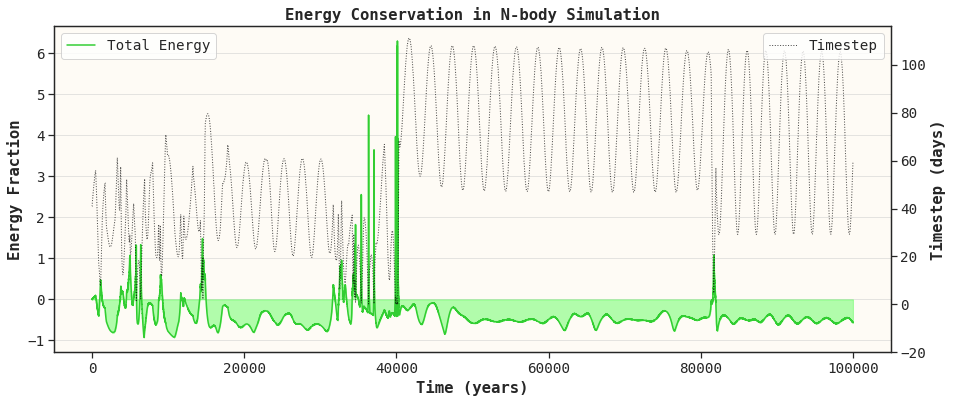

In [39]:
# Set data
x_data = current_time_arr / 365.25
y_data_gpe = GPE
y_data_ke = KE
# y_data = ((totalE - totalE[0]) / totalE[0]) 
y_data_total = ((totalE - totalE[0]) / totalE[0])
y_data_dt = delta_time_arr

# Create the plot
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
ax.grid(axis='y', alpha=0.5)
ax.set_facecolor((254/255, 251/255, 245/255, 1))
# Plot the data
# plt.plot(x_data, y_data_gpe, label='Gravitational Potential Energy (GPE)', linestyle='-', marker='.')
# plt.plot(x_data, y_data_ke, label='Kinetic Energy (KE)', linestyle='-', marker='o')
ax.plot(x_data, y_data_total, label='Total Energy', linestyle='-', color='limegreen', linewidth=1.5)

# Set labels and title
ax.set_xlabel('Time (years)')
ax.set_ylabel('Energy Fraction')
ax.set_title('Energy Conservation in N-body Simulation')

# Create a second y-axis for the timestep
ax2 = ax.twinx()

# Set the y-axis limits
ax2.set_ylim(-20, max(y_data_dt) + 5)

# Plot the timestep data on the secondary y-axis
ax2.plot(x_data, y_data_dt, label='Timestep', linestyle=':', color='black', alpha=0.7, linewidth=1)

# Set the ylabel for the secondary y-axis
ax2.set_ylabel('Timestep (days)')

# Fill the area under the Total Energy curve
ax.fill_between(x_data, 0, y_data_total, alpha=0.3, color='lime')
# ax2.fill_between(x_data, 0, y_data_dt, alpha=0.2)

# Add a legend & show the plot
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

dt

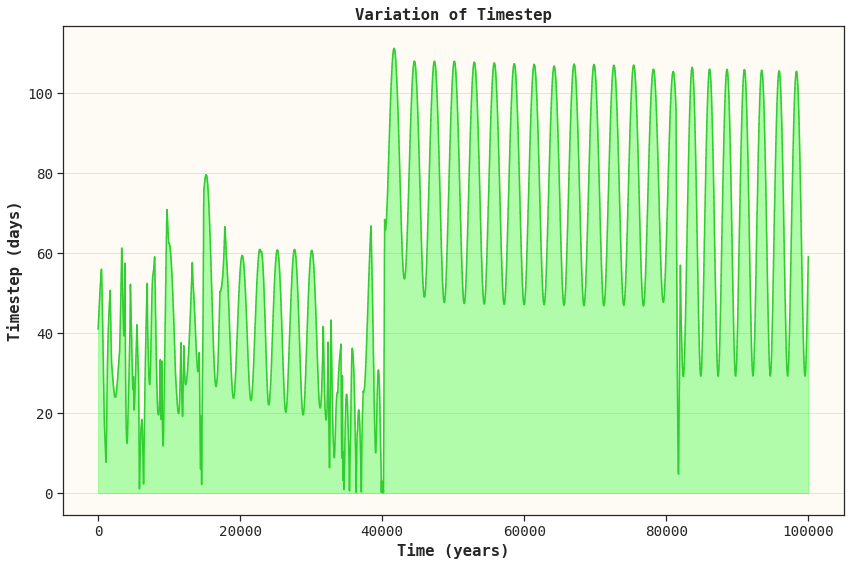

In [47]:
# Set data
x_data = current_time_arr / 365.25
y_data = delta_time_arr

# Create the plot
fig, ax = plt.subplots()
fig.set_size_inches(14, 9)
ax.grid(axis='y', alpha=0.5)
ax.set_facecolor((254/255, 251/255, 245/255, 1))
# Plot the data
# plt.plot(x_data, y_data_gpe, label='Gravitational Potential Energy (GPE)', linestyle='-', marker='.')
# plt.plot(x_data, y_data_ke, label='Kinetic Energy (KE)', linestyle='-', marker='o')
ax.plot(x_data, y_data, label='Total Energy', linestyle='-', color='limegreen', linewidth=1.5)

# Set labels and title
ax.set_xlabel('Time (years)')
ax.set_ylabel('Timestep (days)')
ax.set_title('Variation of Timestep')
ax.fill_between(x_data, 0, y_data, alpha=0.3, color='lime')

# Add a legend & show the plot
# ax.legend(loc='upper left')
plt.show()

##### **3D Plot**

/tmp/ipykernel_32786/1591930180.py:6: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


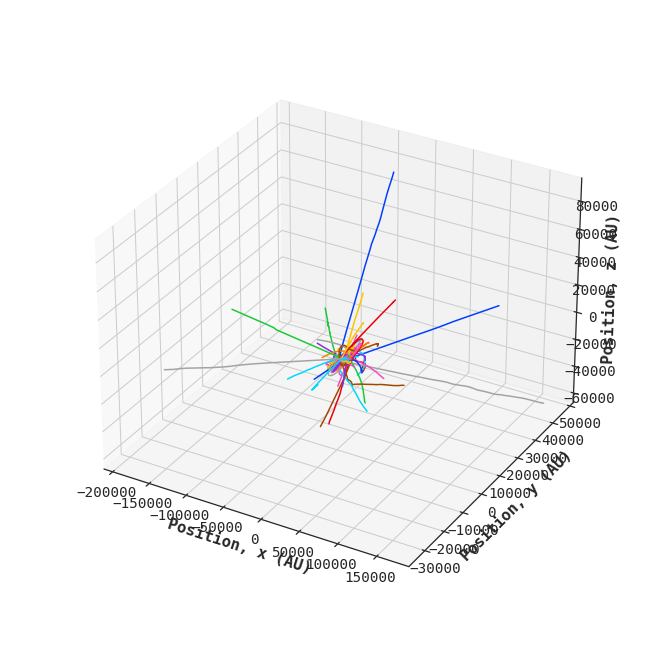

In [21]:
plt.close()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
# fig.gca(projection="3d")
# ax = Axes3D(fig)
ax.dist = 12
ax.set_xlabel('Position, x (AU)')
ax.set_ylabel('Position, y (AU)')
ax.set_zlabel('Position, z (AU)')

for i in range(0, n_bodies):
    x_data = df[f'{i}']['x']
    y_data = df[f'{i}']['y']
    z_data = df[f'{i}']['z']

    ax.plot3D(x_data, y_data, z_data)
# plt.show()

#### **3D Animated Plot**

In [19]:
print(df[f'{1}']['x'][5])

-126.46687


In [20]:
# print the masses of each body
for i in range(0, n_bodies):
    print(f"Mass of body {i} is {df[f'{i}']['mass'][0]}")

Mass of body 0 is 0.04445696994662285
Mass of body 1 is 6.634023666381836
Mass of body 2 is 0.18958619236946106
Mass of body 3 is 0.494439959526062
Mass of body 4 is 0.592308521270752
Mass of body 5 is 12.04407024383545
Mass of body 6 is 0.15654247999191284
Mass of body 7 is 0.5637553930282593
Mass of body 8 is 0.07350048422813416
Mass of body 9 is 0.17279979586601257
Mass of body 10 is 0.36888858675956726
Mass of body 11 is 14.609952926635742
Mass of body 12 is 0.2597563564777374
Mass of body 13 is 4.915734767913818
Mass of body 14 is 0.15268844366073608
Mass of body 15 is 0.3899635672569275
Mass of body 16 is 1.2723426818847656
Mass of body 17 is 0.4231782555580139
Mass of body 18 is 0.9153146147727966
Mass of body 19 is 2.569354772567749
Mass of body 20 is 0.3198552131652832
Mass of body 21 is 2.473954916000366
Mass of body 22 is 0.17720244824886322
Mass of body 23 is 0.2732274830341339
Mass of body 24 is 1.0304877758026123
Mass of body 25 is 1.0457020998001099
Mass of body 26 is 1.

In [28]:
import matplotlib.animation as animation
from IPython.display import HTML

snapshot_interval = 20
trail_length = 600
scaling_factor = 10
plot_limits = 3000

# Initialize the 3D plot
fig = plt.figure(figsize=(12, 12), facecolor=(254/255, 251/255, 245/255, 1))
ax = fig.add_subplot(111, projection='3d')

ax.set_box_aspect(aspect=(3,1,1))

# Set the background color of the plot area
ax.set_facecolor((254/255, 251/255, 245/255, 1))

# Add a text annotation for the time, timestep, and binary counts
annotation = ax.text2D(0.95, 0.95, '', transform=ax.transAxes, ha='right', fontsize=14)

# Set axes labels
ax.set_xlabel('X position $[AU]$', labelpad=20, fontsize=12)
ax.set_ylabel('Y position $[AU]$', labelpad=20, fontsize=12)
ax.set_zlabel('Z position $[AU]$', labelpad=20, fontsize=12)

# Set tick label font size
ax.tick_params(axis='both', which='major', labelsize=9)

# Set axes limits
ax.set_xlim3d(-3000, 17000)
# ax.set_xlim3d(-plot_limits, plot_limits)
ax.set_ylim3d(-plot_limits, plot_limits)
ax.set_zlim3d(-plot_limits, plot_limits)

scatters = [ax.scatter([], [], []) for _ in range(n_bodies)]
lines = [ax.plot([], [], [])[0] for _ in range(n_bodies)]

# Initialize scatter plots
def init():
    for i, scatter in enumerate(scatters):
        x = df[f'{i}']['x'][0]
        y = df[f'{i}']['y'][0]
        z = df[f'{i}']['z'][0]

        mass = df[f'{i}']['mass'][0]
        size = max(1, mass * scaling_factor)
        scatter._offsets3d = ([x], [y], [z])
        scatter.set_sizes([size])
    return scatters

# Animation update function
def update_graph(num):
    for i, scatter in enumerate(scatters):
        # Update the scatter plot
        x = df[f'{i}']['x'][snapshot_indices[num]]
        y = df[f'{i}']['y'][snapshot_indices[num]]
        z = df[f'{i}']['z'][snapshot_indices[num]]
        mass = df[f'{i}']['mass'][0]
        size = mass * scaling_factor
        scatter._offsets3d = ([x], [y], [z])
        scatter.set_sizes([size])

        # Update lines for trailing effect
        start = max(0, snapshot_indices[num] - trail_length)
        end = snapshot_indices[num]
        lines[i].set_data(df[f'{i}']['x'][start:end], df[f'{i}']['y'][start:end])
        lines[i].set_3d_properties(df[f'{i}']['z'][start:end])

    # Update the time, dt, binary count annotation
    current_time = current_time_arr[snapshot_indices[num]]
    current_timestep = delta_time_arr[snapshot_indices[num]]
    current_binaries = binary_counts[snapshot_indices[num]]
    annotation.set_text(f'time: {current_time/365.25:0>9.2f} years\ndeltatime: {current_timestep:0>6.2f} days\nbinaries: {current_binaries}')
    
    return scatters + lines + [annotation]

# Create a list of snapshot indices with the desired interval
snapshot_indices = np.arange(0, total_snapshots, snapshot_interval)
total_snapshots_reduced = len(snapshot_indices)

# Create the animation object
ani = animation.FuncAnimation(fig, update_graph, frames=total_snapshots_reduced, init_func=init, blit=True, interval=20)

# Remove padding and margins
plt.subplots_adjust(left=0, bottom=0, right=0.95, top=1, wspace=None, hspace=None)

plt.close(ani._fig)

# Display the animation
HTML(ani.to_html5_video())

##### 3D Interactive Plot

In [ ]:
# Dataset
iteration_step = 100
data=[go.Scatter3d( x=df.loc[::iteration_step, idx[f'{i}', 'x']], # retrieves every n'th row
                    y = df.loc[::iteration_step, idx[f'{i}', 'y']], 
                    z = df.loc[::iteration_step, idx[f'{i}', 'z']],
                    mode = 'lines',
                    name = f'Body {i}',
                    line = dict(
                        width = np.clip(2*df[f'{i}']['mass'][0], 1, 10),
                        colorscale='Viridis'
                        ))
                    for i in range(n_bodies)]

# Layout
zoom = 1.2
axis_range = [2000,2000,2000] # [x, y, z]
slider_step=50

layout = go.Layout(
    title='N-Body Simulation',
    autosize=False,
    height=900,
    width=1200,
    template=plotly_template,
    scene=dict(
        aspectratio=go.layout.scene.Aspectratio(x=zoom, y=zoom, z=zoom),
        xaxis=dict(
            showgrid=False,
            range=[-axis_range[0], axis_range[0]],
            autorange=False,
        ),
        yaxis=dict(
            showgrid=False,
            range=[-axis_range[1], axis_range[1]],
            autorange=False,
        ),
        zaxis=dict(
            showgrid=False,
            range=[-axis_range[2], axis_range[2]],
            autorange=False,
        ),
    ),
)

fig = go.Figure(data=data, layout=layout)

fig.show()

# import plotly.offline as plotoff
# plotoff.plot(fig, filename='nbody.html')
# pio.write_html(fig, file='nbody.html', auto_open=True)

# testing

In [ ]:
iteration_step = 10000

data = []
for t in range(0, df.index[-1]+1, iteration_step):
    frame = go.Scatter3d(x=[], y=[], z=[], mode='lines')
    for i in range(n_bodies):
        frame.x.append(df.loc[t, idx[f'{i}', 'x']])
        frame.y.append(df.loc[t, idx[f'{i}', 'y']])
        frame.z.append(df.loc[t, idx[f'{i}', 'z']])
        frame.line.width.append(2 * df[f'{i}']['mass'][0])
    data.append(frame)

# Layout
zoom = 1.2
axis_range = 10000
layout = go.Layout(
    title='N-Body Simulation',
    autosize=False,
    height=900,
    width=1400,
    scene=dict(
        aspectratio=go.layout.scene.Aspectratio(x=zoom, y=zoom, z=zoom),
        xaxis=dict(
            showgrid=False,
            range=[-axis_range, axis_range],
            autorange=False,
        ),
        yaxis=dict(
            showgrid=False,
            range=[-axis_range, axis_range],
            autorange=False,
        ),
        zaxis=dict(
            showgrid=False,
            range=[-axis_range, axis_range],
            autorange=False,
        ),
    ),
    updatemenus=[
        dict(
            type='buttons',
            showactive=False,
            buttons=[
                dict(
                    label='Play',
                    method='animate',
                    args=[None, dict(frame=dict(duration=50, redraw=False),
                                     fromcurrent=True,
                                     transition=dict(duration=0),
                                     mode='immediate'
                                     )
                          ]
                ),
                dict(
                    label='Pause',
                    method='animate',
                    args=[[None], dict(mode='immediate',
                                       transition=dict(duration=0),
                                       frame=dict(duration=0, redraw=False),
                                       mode='immediate'
                                       )]
                )
            ]
        ),
    ],
    sliders=[
        dict(
            active=0,
            currentvalue=dict(prefix="Timestep: "),
            steps=[dict(method='animate',
                        args=[[f'frame{k}'],
                              dict(mode='immediate',
                                   frame=dict(duration=100, redraw=False),
                                   transition=dict(duration=0)
                                   )
                          ],
                        label=f'{k * iteration_step}'
                        )
                   for k in range(0, int((df.index[-1]+1) / iteration_step))
],
),
]
)


fig = go.Figure(data=data, layout=layout)

fig.update_layout(
    updatemenus=[dict(type='buttons', showactive=False, buttons=[dict(label='Play', method='animate', args=[None, dict(frame=dict(duration=50, redraw=False), fromcurrent=True, transition=dict(duration=0), mode='immediate')]), dict(label='Pause', method='animate', args=[[None], dict(mode='immediate', transition=dict(duration=0), frame=dict(duration=0, redraw=False), mode='immediate')])])])
fig.update_layout(sliders=[dict(active=0, currentvalue=dict(prefix="Timestep: "), steps=[dict(method='animate', args=[[f'frame{k}'], dict(mode='immediate', frame=dict(duration=100, redraw=False), transition=dict(duration=0))], label=f'{k * iteration_step}') for k in range(0, int((df.index[-1]+1) / iteration_step))])])
fig.show()

In [ ]:
print(x.shape)
print(x.iloc[0])

In [ ]:
# print(df[::2])
# print x position for each body every 100 timesteps
# print(df.loc[::100, idx[:, 'x']])
# print x position for body i every 100 timesteps
i=4
print(df.loc[::100, idx[f'{i}', 'x']])

In [ ]:

# Dataset
iteration_step = 100
data=[go.Scatter3d( x=df.loc[::iteration_step, idx[f'{i}', 'x']], # this only retrieves every iteration_step'th row
                    y=df.loc[::iteration_step, idx[f'{i}', 'y']], 
                    z=df.loc[::iteration_step, idx[f'{i}', 'z']],
                    mode='lines',
                    name=f'Body {i}',
                    line=dict(
                        width=2*df[f'{i}']['mass'][0],
                        colorscale='Viridis'
                        ))
                    # line=dict(width=2*df[f'{i}']['mass'][0], color='blue'))
                    for i in range(n_bodies)]


    
# make a slider to go forward and backward in time
steps = []
for i in range(0, total_iterations, iteration_step):
    step = dict(
        method="animate",
        args=[
            [i],
            dict(
                frame=dict(duration=0, redraw=True),
                mode="immediate",
                transition=dict(duration=0),
            ),
        ],
        label=f"{i}",
    )
    steps.append(step)

sliders = [
    dict(
        active=0,
        currentvalue={"prefix": "Iteration: "},
        pad={"t": 50},
        steps=steps,
    )
]

# layout["sliders"] = sliders
# Layout
zoom = 1.2
axis_range = 10000
layout = go.Layout(
    title='N-Body Simulation',
    autosize=False,
    height=900,
    width=1400,
    template=plotly_template,
    updatemenus=[
        dict(
            type="buttons",
            buttons=[
                dict(
                    label="Play",
                    method="animate",
                    args=[
                        None,
                        dict(
                            frame=dict(duration=0, redraw=True),
                            fromcurrent=True,
                            transition=dict(duration=0),
                            mode="immediate",
                        ),
                    ],
                ),
                dict(
                    label="Pause",
                    method="animate",
                    args=[
                        [None],
                        dict(
                            frame=dict(duration=0, redraw=True),
                            mode="immediate",
                            transition=dict(duration=0),
                        ),
                    ],
                ),
            ],
        )
    ],
    sliders=sliders,
    scene=dict(
        aspectratio=go.layout.scene.Aspectratio(x=zoom, y=zoom, z=zoom),
        xaxis=dict(
            showgrid=False,
            range=[-axis_range, axis_range],
            autorange=False,
        ),
        yaxis=dict(
            showgrid=False,
            range=[-axis_range, axis_range],
            autorange=False,
        ),
        zaxis=dict(
            showgrid=False,
            range=[-axis_range, axis_range],
            autorange=False,
        ),
    ),
)

# now make the slider animate the data
# frames = []
# for i in range(0, total_iterations, iteration_step):
#     frame = dict(
#         data=[go.Scatter3d( x=df.loc[i, idx[f'{j}', 'x']], # this only retrieves every iteration_step'th row
#                             y=df.loc[i, idx[f'{j}', 'y']], 
#                             z=df.loc[i, idx[f'{j}', 'z']],
#                             mode='lines',
#                             name=f'Body {j}',
#                             line=dict(
#                                 width=2*df[f'{j}']['mass'][0],
#                                 colorscale='Viridis'
#                                 ))
#                             # line=dict(width=2*df[f'{j}']['mass'][0], color='blue'))
#                             for j in range(n_bodies)],
#         traces=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
#         name=f"{i}",
#     )
#     frames.append(frame)

# fig = go.Figure(data=data, layout=layout, frames=frames)


fig = go.Figure(data=data, layout=layout, frames=frames)
# fig.update_layout(template=plotly_template)
# fig.update_layout(yaxis_range=[-1, 1])

# fig.update_layout(

# )

fig.show()

# import plotly.offline as plotoff
# plotoff.plot(fig, filename='nbody.html')
# pio.write_html(fig, file='nbody.html', auto_open=True)

In [ ]:
i=1
xf = df.loc[::iteration_step, idx[f'{i}', 'x']]
# print(xf[,0])
xf.shape
# print first 10 values in xf
print(xf[0:10])

In [ ]:
# # Dataset
# data=[go.Scatter3d(x=df[f'{i}']['x'], 
#                     y=df[f'{i}']['y'], 
#                     z=df[f'{i}']['z'],
#                     mode='lines',
#                     name=f'Body {i}',
#                     line=dict(
#                         width=2*df[f'{i}']['mass'][0],
#                         colorscale='Viridis'
#                         ))
#                     # line=dict(width=2*df[f'{i}']['mass'][0], color='blue'))
#                     for i in range(n_bodies)]

# # Layout
# zoom = 1.2

# layout = go.Layout(
#     title='N-Body Simulation',
#     autosize=False,
#     height=900,
#     width=1400,
#     scene=dict(
#         aspectratio=go.layout.scene.Aspectratio(x=zoom, y=zoom, z=zoom)
#         ),
# )
    
# fig = go.Figure(data=data, layout=layout)
# fig.update_layout(template=plotly_template)
# fig.show()

